Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [1]:
%pip install torchaudio
%pip install  pydub
%pip install soundfile
%pip install wandb
import wandb
import os
import torch
import torchaudio
import soundfile as sf
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [2]:
project_name='Music_genre_classification'

batch_size = 64
learning_rate = 0.001
epochs = 50

#Experimentos NN + waveform
experiment_name = 'Iden_1capa_densa'
#experiment_name = 'Iden_3capas_NOdensa'
#experiment_name = 'Iden_3capas_densa'


In [3]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="larabarijhoff-universidad-torcuato-di-tella",
    # Set the wandb project where this run will be logged.
    project="tp3-td6-25",
    # Track hyperparameters and run metadata.
    name = experiment_name
)

# Finish the run and upload any remaining data.
# run.finish()

wandb: Currently logged in as: larabarijhoff (larabarijhoff-universidad-torcuato-di-tella) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Experimentos NN

In [4]:
if experiment_name == 'Iden_1capa_densa':
    model = nn.Sequential(
    nn.Linear(110250, 10), #primera capa oculta
)
    
if experiment_name == 'Iden_3capas_NOdensa':
    model = nn.Sequential(
    nn.Linear(110250, 50), #primera capa oculta
    nn.Identity(),
    nn.Linear(50, 40), #segunda capa oculta
    nn.Identity(),
    nn.Linear(40, 10)  # tercera capa
)
    
#LA DE MEJOR RESULTADO
if experiment_name == 'Iden_3capas_densa':
    model = nn.Sequential(
    nn.Linear(110250, 1024), #primera capa oculta
    nn.Identity(),
    nn.Linear(1024, 512), #segunda capa oculta
    nn.Identity(),
    nn.Linear(512, 10)  # tercera capa
)

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
data_dir="..\genres_5sec" #para lari
#data_dir="../genres_5sec" #para piki
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [6]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [ ]:
# Proba cargar un archivo válido lara
waveform, sr = torchaudio.load(r'..\genres_5sec\blues\blues.00000.wav') #para lari
#waveform, sr = torchaudio.load(r'../genres_5sec/blues/blues.00000.wav') #para piki
print(waveform.shape, sr)

torch.Size([1, 110250]) 22050


In [8]:
waveform,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 0 


shape of spectogram torch.Size([1, 201, 552])


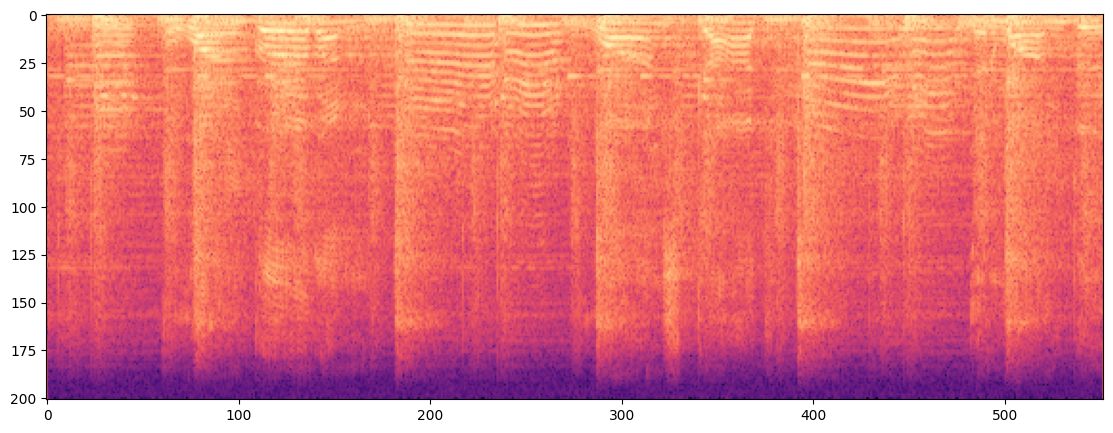

In [9]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.1055, -0.1083, -0.1056]])



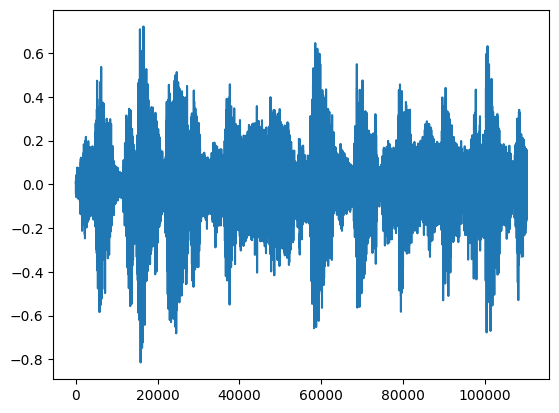

In [10]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [11]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [12]:
specgram.size()

torch.Size([1, 201, 552])

In [13]:
# Fijar la semilla para que la división sea reproducible
random_seed = 42
torch.manual_seed(random_seed)

# Calcular tamaños basados en porcentajes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Dividir el dataset
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Comprobación de los tamaños de cada subconjunto
len(train_ds), len(val_ds), len(test_ds)

(792, 99, 99)

In [14]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
# Prueba para verificar si el DataLoader de entrenamiento funciona correctamente
try:
    for data, labels in train_dl:
        print("Forma de los datos:", data.shape)
        print("Etiquetas:", labels)
        break  # Carga solo el primer batch
except Exception as e:
    print("Error al cargar los datos del train_dl:", e)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=0, pin_memory=True)

c:\Users\laras\miniconda3\envs\metodos\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Forma de los datos: torch.Size([64, 1, 110250])
Etiquetas: tensor([8, 1, 3, 0, 2, 8, 0, 1, 9, 9, 2, 9, 6, 0, 0, 3, 6, 2, 2, 8, 4, 6, 3, 6,
        0, 2, 9, 8, 1, 6, 9, 6, 2, 5, 5, 5, 3, 1, 9, 3, 5, 2, 9, 6, 7, 5, 4, 2,
        1, 6, 8, 7, 3, 3, 6, 8, 0, 3, 9, 5, 1, 7, 0, 6])


### 4. Clasificación

### NN

In [15]:
# dada por ellos:

#1 Capa densa
class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=64, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, n_output)  # First hidden layer

    def forward(self, x):
       x = self.fc1(x)
       return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else
                      'cpu')

model = MLP(n_input=110250, n_output=len(classes))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

MLP(
  (fc1): Linear(in_features=110250, out_features=10, bias=True)
)
Number of parameters: 1102510


In [17]:
len(classes)

10

In [18]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
valid_losses = []
num_epochs = epochs
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram

best_valid_accuracy = 0

for epoch in range(num_epochs):
    losses = []

    # Train
    model.train()
    for wav, genre_index in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        #M5
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram
        wandb.log({'train_loss': np.mean(losses)}, commit = False)

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in valid_dl:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = loss_function(out.squeeze() , genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    valid_accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, valid_accuracy))

    # Guardar el mejor modelo según la precisión de validación
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model.ckpt')

    wandb.log({
        'val_loss': valid_loss,         # Pérdida de validación calculada arriba
        'val_accuracy': valid_accuracy        # Exactitud de validación calculada arriba
        })

c:\Users\laras\miniconda3\envs\metodos\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: [1/50], Train loss: 2.3176
Epoch: [1/50], Valid loss: 2.3515, Valid accuracy: 0.1111
Epoch: [2/50], Train loss: 0.7179
Epoch: [2/50], Valid loss: 2.3778, Valid accuracy: 0.1313
Epoch: [3/50], Train loss: 0.3931
Epoch: [3/50], Valid loss: 2.4311, Valid accuracy: 0.1111
Epoch: [4/50], Train loss: 0.2682
Epoch: [4/50], Valid loss: 2.4670, Valid accuracy: 0.1212
Epoch: [5/50], Train loss: 0.2103
Epoch: [5/50], Valid loss: 2.5013, Valid accuracy: 0.1414
Epoch: [6/50], Train loss: 0.1803
Epoch: [6/50], Valid loss: 2.5321, Valid accuracy: 0.1414
Epoch: [7/50], Train loss: 0.1455
Epoch: [7/50], Valid loss: 2.5606, Valid accuracy: 0.1414
Epoch: [8/50], Train loss: 0.1284
Epoch: [8/50], Valid loss: 2.5897, Valid accuracy: 0.1414
Epoch: [9/50], Train loss: 0.1163
Epoch: [9/50], Valid loss: 2.6166, Valid accuracy: 0.1313
Epoch: [10/50], Train loss: 0.1013
Epoch: [10/50], Valid loss: 2.6414, Valid accuracy: 0.1212
Epoch: [11/50], Train loss: 0.0931
Epoch: [11/50], Valid loss: 2.6659, Valid a



### 5. Evaluación



In [19]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=0, pin_memory=True)

In [20]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for wav, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

test_accuracy = correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Test accuracy: %.4f' % (epoch+1, num_epochs, test_accuracy))

# Registrar la precisión y la pérdida en W&B
wandb.summary["test_accuracy"]= test_accuracy



loaded!
Epoch: [50/50], Test accuracy: 0.1414


In [21]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 


In [22]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [23]:
wav= torch.unsqueeze(waveform, dim=0)
model.to(device)
wav =wav.to(device)
out = model(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]

('metal', 'rock')

In [24]:
print(test_accuracy)
print(valid_accuracy)
print(valid_loss)

0.1414141414141414
0.13131313131313133
3.322908878326416
